${\Large \textbf{C0: Read Hs from SAR}}$  
In this notebook, we explore the $H_s$ of SARWAVE, and we plot them against KaRIn's $H_s$.  
We also investigate the oceanographic context through wave models, and perform a bit of comparison at SWOT nadir

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import SWOT_tools as st
import xarray as xr
import shapefile as shp 
import os
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import griddata
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches

In [2]:
#plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})

import matplotlib.font_manager as fm
# Regular and bold font paths
font_regular_path = "fonts/times/times.ttf"
font_bold_path = "fonts/times/timesbd.ttf"  # Bold
# Register both fonts
fm.fontManager.addfont(font_regular_path)
fm.fontManager.addfont(font_bold_path)
# Create font properties
font_regular = fm.FontProperties(fname=font_regular_path)
font_bold = fm.FontProperties(fname=font_bold_path)
# Set default font to regular Times New Roman
plt.rcParams['font.family'] = font_regular.get_name()

In [3]:
sar_file_root = r"data/iw/l2/"
swot_root = r"data/swot/"


### Selection of the desired case ###

#year_and_day = "2023/270/"
#year_and_day = "2024/142/"
#year_and_day = "2024/211/"
#year_and_day = "2024/295/"
#year_and_day = "2024/304/"
year_and_day = "2025/129/"

sar_file_root += year_and_day
swot_root += year_and_day




100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


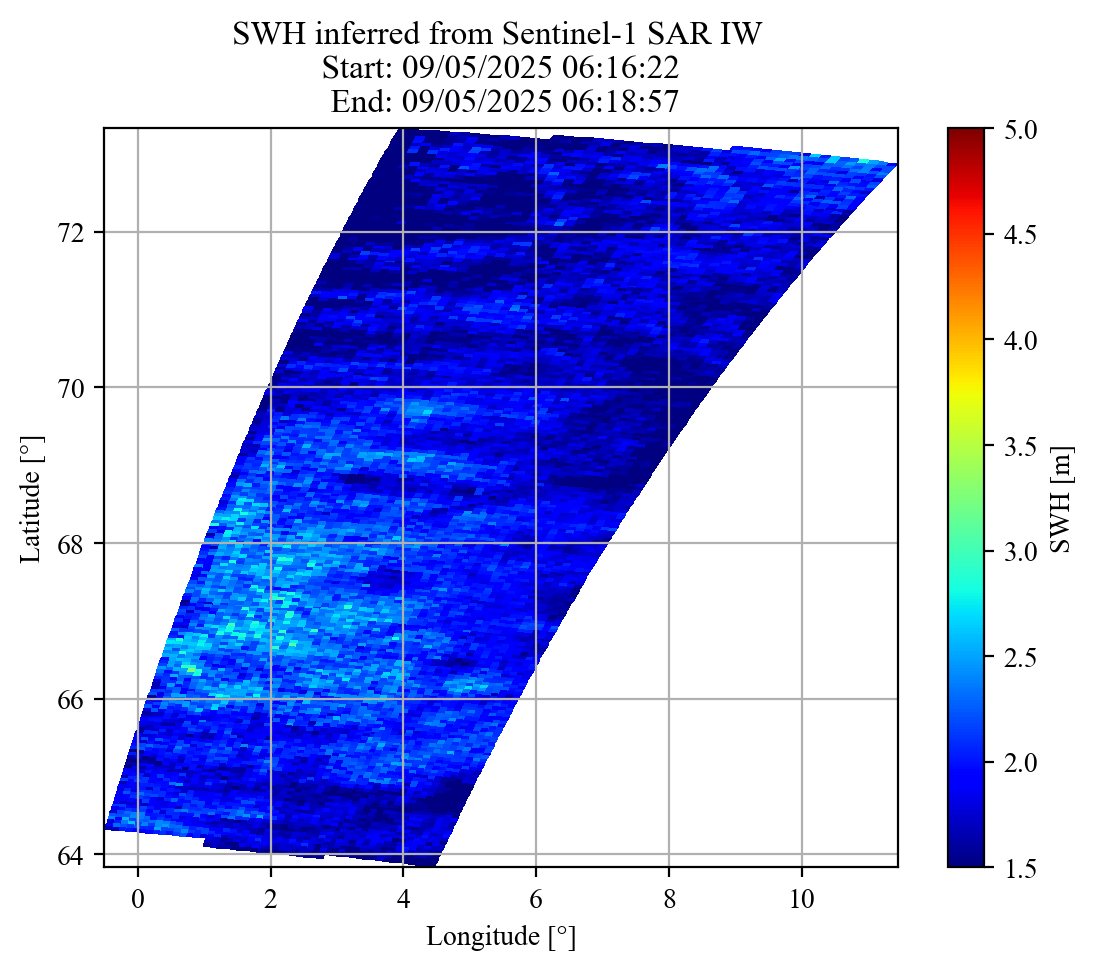

In [5]:
iw_files = {"iw1": None, "iw2": None, "iw3": None}
plt.figure(dpi=200)

dt_ini_min =  datetime.strptime("20310927T163757", "%Y%m%dT%H%M%S") # 2031 pour être sûr qu'il sera jamais pris en date de début
dt_end_max =  datetime.strptime("20010927T163857", "%Y%m%dT%H%M%S") # 2001 pour être sûr qu'il sera jamais pris en date de fin

lon_map_min, lon_map_max = 180, -180 # valeurs extrêmes exprès pour que ça se mette bien
lat_map_min, lat_map_max = 90, -90

for iw_dir in tqdm(os.listdir(sar_file_root)):    
    for f in os.listdir(sar_file_root + iw_dir):
        if f.endswith(".nc"):
            # On trie pour mettre dans le bon ordre
            for iw_pat in iw_files:
                if iw_pat in f:
                    iw_files[iw_pat] = os.path.join(sar_file_root + iw_dir, f)
                    

    dt_ini = datetime.strptime(iw_files["iw1"][37:52], "%Y%m%dT%H%M%S")
    if dt_ini < dt_ini_min:
        dt_ini_min = dt_ini

    dt_end = datetime.strptime(iw_files["iw1"][53:68], "%Y%m%dT%H%M%S")
    if dt_end > dt_end_max:
        dt_end_max = dt_end

    ds1 = xr.open_dataset(iw_files["iw1"], group='intraburst') # ds_intra, iw1
    ds2 = xr.open_dataset(iw_files["iw2"], group='intraburst') # ds_intra, iw2
    ds3 = xr.open_dataset(iw_files["iw3"], group='intraburst') # ds_intra, iw3

    ds_list = [ds1, ds2, ds3]
    
    for ds in tqdm(ds_list):
        # Si d'aventure un jour c'est trop lent, on peut tenter la technique de Vadream avec le xr.openmf_dataset ou un truc du style (pour tout avoir d'un coup)
        lon, lat = ds.variables["longitude"].values, ds.variables["latitude"].values
        
        if np.nanmin(lon) < lon_map_min:
            lon_map_min = np.nanmin(lon)
        if np.nanmax(lon) > lon_map_max:
            lon_map_max = np.nanmax(lon)
            
        if np.nanmin(lat) < lat_map_min:
            lat_map_min = np.nanmin(lat)
        if np.nanmax(lat) > lat_map_max:
            lat_map_max = np.nanmax(lat)
        
        hsml = ds.variables["hs_most_likely"].values

        plt.pcolormesh(lon, lat, hsml, cmap="jet",vmin=1.5, vmax=5)
        
plt.title("SWH inferred from Sentinel-1 SAR IW \n Start: {} \n End: {}".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S')))
plt.colorbar(label="SWH [m]")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.grid()
plt.show()

In [6]:
###################################
### Chargement de la trace SWOT ###
###################################

which_swot_track = "night"
which_swot_track = "morning"

if which_swot_track == "night":
    swot_track = os.listdir(swot_root)[1]
else: 
    swot_track = os.listdir(swot_root)[0]
    
ds_swot = xr.open_dataset(os.path.join(swot_root,swot_track))
ds_swot, t_ini_swot_formatted, t_end_swot_formatted = st.format_ds_swot(ds_swot, lon_map_min, lon_map_max, lat_map_min, lat_map_max, untrustable_hs=40, kernel_size_nan=1, step_to_crop_at_edges=2)
hs_max = round(np.nanpercentile(ds_swot.swh_karin.values,99),1)
hs_min = round(np.nanpercentile(ds_swot.swh_karin.values,1),1)

In [7]:
#########################
### SIGMA0 vs HS SWOT ###
#########################

# Estimation des bornes de la colorbar
hs_max = round(np.nanpercentile(ds_swot.swh_karin.values,99),1)
hs_min = round(np.nanpercentile(ds_swot.swh_karin.values,1),1)
cmap_levels = np.arange(hs_min,hs_max,0.05)



# KaRIn PART
show_hs_swot = False
if show_hs_swot:
    ### Début du ploplot
    f, ax = plt.subplots(1,1, figsize=(17,7))

    plt.suptitle("SWOT SWH", fontsize=18)

    #ds_swot.swh_karin.plot.contourf(x='longitude', y='latitude', ax=ax,levels=cmap_lofoten_levels, cmap=cmap, add_colorbar=True, alpha=0.35, extend='both')    
    #ds_swot.swh_karin.plot.contourf(x='longitude', y='latitude', ax=ax, levels=cmap_levels, cmap="jet", add_colorbar=True, alpha=0.5, extend='both')    
    ds_swot.swh_karin.plot.pcolormesh(x='longitude', y='latitude', ax=ax, levels=cmap_levels, cmap="jet", add_colorbar=True, extend='both')    
    #ax.set_aspect('equal')
    plt.grid()
    plt.show()


show_sigma0_swot = False
cmap_levels = np.arange(0,15,1)


if show_sigma0_swot:
    f, ax = plt.subplots(1,1, figsize=(17,7))
    ds_swot.wind_speed_karin.plot.pcolormesh(x='longitude', y='latitude', ax=ax, cmap="viridis", add_colorbar=True, extend='both')    
    plt.grid()
    plt.show()
    
    f, ax = plt.subplots(1,1, figsize=(17,7))
    ds_swot.pipe(lambda ds: ds.sig0_karin_2 -  ds.sig0_karin).plot.pcolormesh(x='longitude', y='latitude', ax=ax, cmap="seismic", add_colorbar=True, extend='both') 
    #ds_swot.sig0_karin_2.plot.pcolormesh(x='longitude', y='latitude', ax=ax, levels= cmap_levels, cmap="viridis", add_colorbar=True, extend='both')    
    plt.grid()
    plt.show()
    
    
    f, ax = plt.subplots(1,1, figsize=(17,7))
    ds_swot.sig0_karin.plot.pcolormesh(x='longitude', y='latitude', ax=ax, levels= cmap_levels, cmap="viridis", add_colorbar=True, extend='both')    
    plt.grid()
    plt.show()

    f, ax = plt.subplots(1,1, figsize=(17,7))
    ds_swot.sig0_karin_2.plot.pcolormesh(x='longitude', y='latitude', ax=ax, levels= cmap_levels, cmap="viridis", add_colorbar=True, extend='both')    
    plt.grid()
    plt.show()
#ds_l3_night.ssha_filtered.plot.contourf(x='longitude', y='latitude', ax=ax,levels=cmap_lofoten_levels, cmap=cmap, add_colorbar=True, extend='both')   
#ds_l3_morning.ssha_filtered.plot.contourf(x='longitude', y='latitude', ax=ax, cmap=cmap, add_colorbar=True, extend='both')   



100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


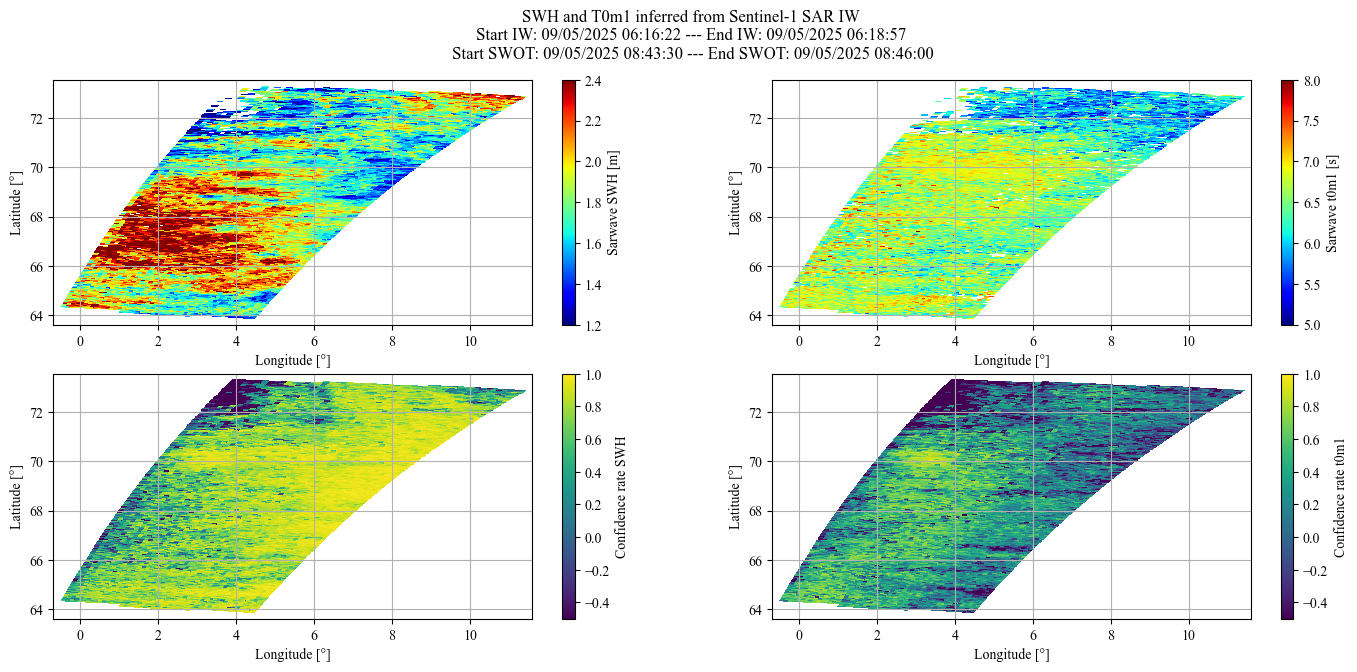

In [8]:
#################################################################
### Plotting Hs and T0m1 from SARWAVE with SWOT Hs boundaries ###
#################################################################


show_hs = True
show_t0m1 = True
step_deg = 0.25 # for adjusting plot boundaries


fig, ax = plt.subplots(2,2, figsize=(17,7))

ds_mega_list=[]

for iw_dir in tqdm(os.listdir(sar_file_root)):    
    for f in os.listdir(sar_file_root + iw_dir):
        if f.endswith(".nc"):
            # On trie pour mettre dans le bon ordre
            for iw_pat in iw_files:
                if iw_pat in f:
                    iw_files[iw_pat] = os.path.join(sar_file_root + iw_dir, f)

    ds1 = xr.open_dataset(iw_files["iw1"], group='intraburst') # ds_intra, iw1
    ds2 = xr.open_dataset(iw_files["iw2"], group='intraburst') # ds_intra, iw2
    ds3 = xr.open_dataset(iw_files["iw3"], group='intraburst') # ds_intra, iw3

    ds_list = [ds1, ds2, ds3]
    ds_mega_list += ds_list
    for ds in tqdm(ds_list):
        lon, lat = ds.variables["longitude"].values, ds.variables["latitude"].values
        
        # Hs part
        hsml = ds.variables["hs_most_likely"].values

        
        hs_conf = ds.variables["hs_conf"].values
        conf_rate_min = -0.5
        mask_confident = hs_conf > conf_rate_min # hs_conf [-1,1] so 0 is 50%-50%
        hsml_confident = np.ones(hsml.shape)*np.nan
        hsml_confident[mask_confident] = hsml[mask_confident]
        
        if show_hs:
            im_00 = ax[0,0].pcolormesh(lon, lat, hsml_confident, cmap="jet",vmin=hs_min, vmax=hs_max)
            im_10 = ax[1,0].pcolormesh(lon, lat, hs_conf, cmap="viridis",vmin=conf_rate_min, vmax = 1)

        # T part
        t0m1_ml = ds.variables["t0m1_most_likely"].values
        t0m1_conf = ds.variables["t0m1_conf"].values
        t0m1_conf_rate_min = -0.5
        t0m1_mask_confident = t0m1_conf > t0m1_conf_rate_min # t0m1_conf [-1,1] so 0 is 50%-50%
        t0m1_confident = np.ones(t0m1_ml.shape)*np.nan
        t0m1_confident[t0m1_mask_confident] = t0m1_ml[t0m1_mask_confident]

        if show_t0m1:
            im_01 = ax[0,1].pcolormesh(lon, lat, t0m1_confident, cmap="jet",vmin=5, vmax=8)
            im_11 = ax[1,1].pcolormesh(lon, lat, t0m1_conf, cmap="viridis",vmin=conf_rate_min, vmax=1)

        

#plt.colorbar(label="SWH [m]")
# KaRIn PARTlat_map_min
#show_hs_swot = False
#if show_hs_swot:
#    ds_swot.swh_karin.plot.pcolormesh(x='longitude', y='latitude', ax=ax[0], levels=cmap_levels, cmap="jet", add_colorbar=True, alpha=0.9, extend='both')    

plt.suptitle("SWH and T0m1 inferred from Sentinel-1 SAR IW\n Start IW: {} --- End IW: {} \n Start SWOT: {} --- End SWOT: {}".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted))

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim(lon_map_min-step_deg, lon_map_max+step_deg)
        ax[i,j].set_ylim(lat_map_min-step_deg, lat_map_max+step_deg)
        ax[i,j].set_xlabel("Longitude [°]")
        ax[i,j].set_ylabel("Latitude [°]")
        ax[i,j].grid()

fig.colorbar(im_00, ax=ax[0,0], orientation='vertical', label = "Sarwave SWH [m]")
fig.colorbar(im_10, ax=ax[1,0], orientation='vertical', label = "Confidence rate SWH")
fig.colorbar(im_01, ax=ax[0,1], orientation='vertical', label = "Sarwave t0m1 [s]")
fig.colorbar(im_11, ax=ax[1,1], orientation='vertical', label = "Confidence rate t0m1")

fig.show()


dx (km): 481.36, dy (km): 1054.54, scale: 2.19


/dev/shm/pbs.3818094.datarmor0/ipykernel_4667/73504444.py:107: RuntimeWarning: All-NaN slice encountered
  diff = round(np.nanmax(np.abs(hsml - swot_interp_on_iw_grid)),1)
/dev/shm/pbs.3818094.datarmor0/ipykernel_4667/73504444.py:115: RuntimeWarning: All-NaN slice encountered
  min_iw_i, max_iw_i = np.nanmin([np.nanmin(swot_interp_on_iw_grid), np.nanmin(hsml)]),  np.nanmax([np.nanmax(swot_interp_on_iw_grid), np.nanmax(hsml)])


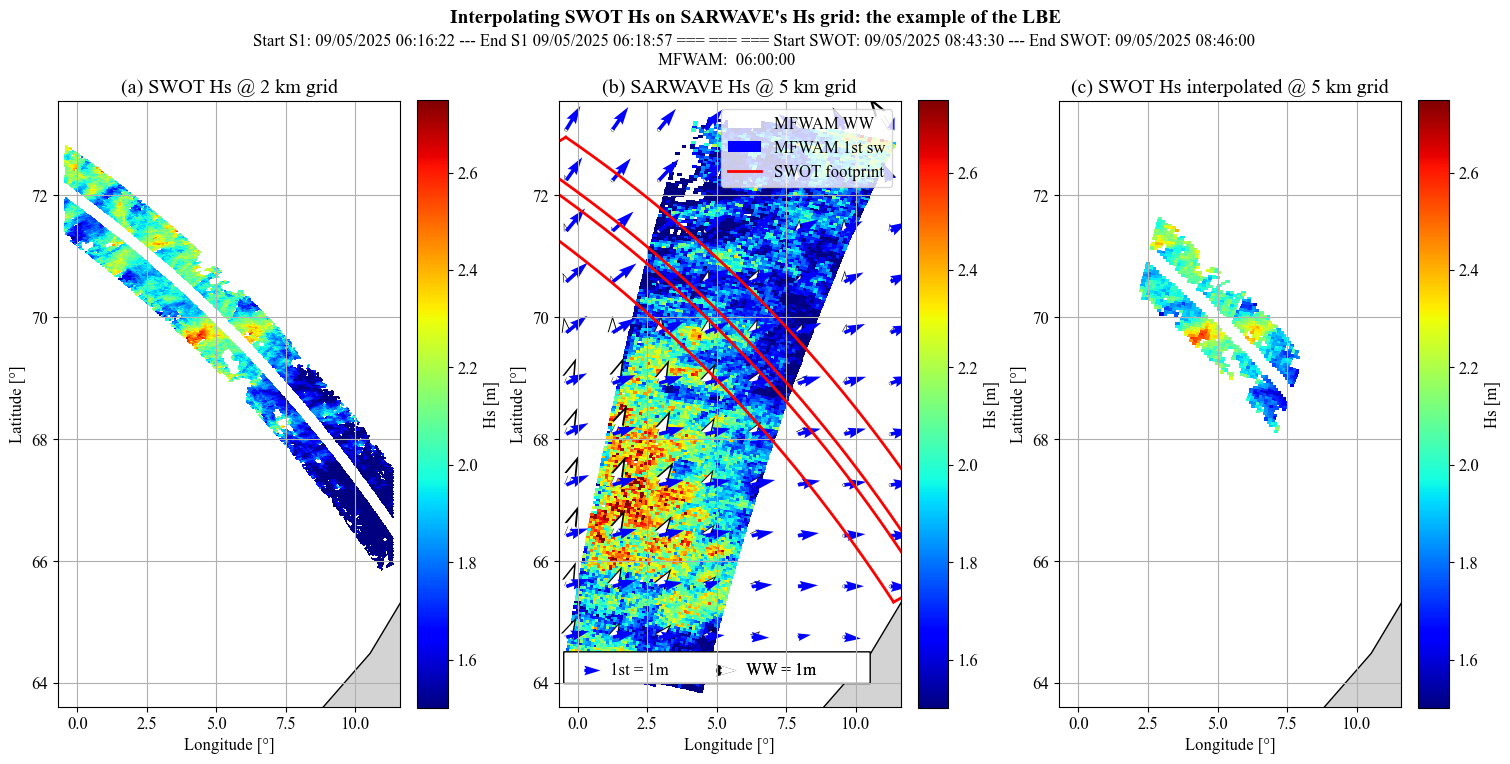

In [9]:
########################################################################
#                                                                      #
########################################################################
#### INTERPOLATING 2km x 2km SWOT grid onto 5km x 5 km IW SARWAVE grid #  
########################################################################
#                                                                      #
########################################################################

plt.rcParams.update({'font.size': 12})  
hs_min, hs_max = 1.5, 2.75

# Geographic scaling
Rt = 6400  # km
mean_lat_rad = np.radians((lat_map_min + lat_map_max)/2)
dx = Rt * np.cos(mean_lat_rad) * np.radians(lon_map_max - lon_map_min)
dy = Rt * np.radians(lat_map_max - lat_map_min)
scale_fact = dy / dx

print(f"dx (km): {dx:.2f}, dy (km): {dy:.2f}, scale: {scale_fact:.2f}")

# Full figure size
Lx = 5  # inches
Ly = Lx * scale_fact



# 2km x 2km SWOT images
lon_swot_grid = ds_swot.longitude.values
lat_swot_grid = ds_swot.latitude.values
swh_swot_grid = ds_swot.swh_karin.values
lon_swot_flat = ds_swot.longitude.values.ravel()
lat_swot_flat = ds_swot.latitude.values.ravel()
swh_swot_flat = ds_swot.swh_karin.values.ravel()
swot_points = np.vstack((lon_swot_flat, lat_swot_flat)).T

swot_lon_min, swot_lon_max = lon_swot_flat.min(), lon_swot_flat.max()
swot_lat_min, swot_lat_max = lat_swot_flat.min(), lat_swot_flat.max()

swh_swot_interp_array_tot = np.array([])
swh_iw_array_tot = np.array([]) # ça va être flatten pour la régression linéaire qu'on fait ensuite
swh_iw_conf_array_tot = np.array([])
                            
#fig, axs = plt.subplots(1, 3, figsize=(15, 6), constrained_layout = True)
n_p = 3
fig, axs = plt.subplots(1, n_p, figsize=(3*Lx, Ly), constrained_layout = True)

# Set the same aspect ratio for all subplots
for ax in axs.flat:
    ax.set_aspect(scale_fact)  # or use dy/dx if you want numerical precision: ax.set_aspect(scale_fact)



min_xx, max_xx = 100, -100
diff_max = 0

# Plot original fine grid
im0 = axs[0].pcolormesh(lon_swot_grid, lat_swot_grid, swh_swot_grid, shading='auto', cmap='jet', vmin=hs_min, vmax=hs_max)



INTERP_SWOT_ON_IW_LIST = []


# 5km x 5km IW images
for ds in ds_mega_list:
#ds = ds3
    iw_lon_grid = ds.longitude.values
    iw_lat_grid = ds.latitude.values
    interp_points = np.vstack((iw_lon_grid.ravel(), iw_lat_grid.ravel())).T
    
    # Mask for overlapping region
    mask = (
        (iw_lon_grid >= swot_lon_min) & (iw_lon_grid <= swot_lon_max) &
        (iw_lat_grid >= swot_lat_min) & (iw_lat_grid <= swot_lat_max)
    )
    
    # Only interpolate where mask is True
    swot_interp_on_iw_grid = np.full(iw_lon_grid.shape, np.nan)  # NaN elsewhere
    
    # Apply interpolation
    interpolated_values = griddata(
        swot_points, swh_swot_flat, 
        (iw_lon_grid[mask], iw_lat_grid[mask]), 
        method='linear'
    )
    
    swot_interp_on_iw_grid[mask] = interpolated_values
    INTERP_SWOT_ON_IW_LIST.append(swot_interp_on_iw_grid)
    
    swh_swot_interp_array_tot = np.concatenate((swh_swot_interp_array_tot,swot_interp_on_iw_grid.ravel()))
    
    #print("swot_shape",swot_interp_on_iw_grid.shape)
    
       
    lon, lat = ds.variables["longitude"].values, ds.variables["latitude"].values
    hsml = ds.variables["hs_most_likely"].values
    swh_iw_array_tot = np.concatenate((swh_iw_array_tot, hsml.ravel()))

    hs_conf = ds.variables["hs_conf"].values
    mask_confident = hs_conf > conf_rate_min # hs_conf [-1,1] so 0 is 50%-50%
    hsml_confident = np.ones(hsml.shape)*np.nan
    hsml_confident[mask_confident] = hsml[mask_confident]
    swh_iw_conf_array_tot = np.concatenate((swh_iw_conf_array_tot,  hsml_confident.ravel()))
    #print("hsml_shape",hsml.shape)

    try:
        diff = round(np.nanmax(np.abs(hsml - swot_interp_on_iw_grid)),1)
        if diff > diff_max:
            diff_max = diff
    except ValueError:
        pass
        
     
    try:
        min_iw_i, max_iw_i = np.nanmin([np.nanmin(swot_interp_on_iw_grid), np.nanmin(hsml)]),  np.nanmax([np.nanmax(swot_interp_on_iw_grid), np.nanmax(hsml)])
        if min_iw_i < min_xx:
            min_xx = min_iw_i
        if max_iw_i > max_xx:
            max_xx = max_iw_i
    except ValueError:
        pass


for i, ds in enumerate(ds_mega_list):
    swot_interp_on_iw_grid = INTERP_SWOT_ON_IW_LIST[i]

    iw_lon_grid = ds.longitude.values
    iw_lat_grid = ds.latitude.values
    
    lon, lat = ds.variables["longitude"].values, ds.variables["latitude"].values
    hsml = ds.variables["hs_most_likely"].values
    
    hs_conf = ds.variables["hs_conf"].values
    mask_confident = hs_conf > conf_rate_min # hs_conf [-1,1] so 0 is 50%-50%
    hsml_confident = np.ones(hsml.shape)*np.nan
    hsml_confident[mask_confident] = hsml[mask_confident]
    

    im1 = axs[1].pcolormesh(lon, lat, hsml_confident, cmap="jet", vmin=hs_min, vmax=hs_max)

    im2 = axs[2].pcolormesh(lon, lat, swot_interp_on_iw_grid, shading='auto', cmap='jet', vmin=hs_min, vmax=hs_max)

    #im3 = axs[3].pcolormesh(lon, lat, swot_interp_on_iw_grid-hsml_confident, cmap="seismic", vmin=-diff_max, vmax=diff_max)



### Chargement de MFWAM
time_mfwam_idx = 1 # 06:00:00
ds_mfwam = xr.open_dataset(r"data/mfwam/mfwamglocep_2025050900_R20250510_00H.nc")
ds_mfwam = ds_mfwam.where((ds_mfwam.longitude >= lon_map_min) & (ds_mfwam.longitude <= lon_map_max) & (ds_mfwam.latitude >= lat_map_min) & (ds_mfwam.latitude <= lat_map_max), drop=True)

X_mfwam, Y_mfwam = ds_mfwam.longitude.values, ds_mfwam.latitude.values
X_mfwam_grid, Y_mfwam_grid = np.meshgrid(X_mfwam, Y_mfwam)

mean_wave_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR.values
hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0.values
u_mean_wave_dir = hs*np.sin(np.pi*(mean_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_mean_wave_dir = hs*np.cos(np.pi*(mean_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

sw1_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_SW1.values
sw1_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_SW1.values
u_sw1_dir = sw1_hs*np.sin(np.pi*(sw1_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_sw1_dir = sw1_hs*np.cos(np.pi*(sw1_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

sw2_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_SW2.values
sw2_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_SW2.values
u_sw2_dir = sw2_hs*np.sin(np.pi*(sw2_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_sw2_dir = sw2_hs*np.cos(np.pi*(sw2_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

ww_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_WW.values
ww_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_WW.values
u_ww_dir = ww_hs*np.sin(np.pi*(ww_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_ww_dir = ww_hs*np.cos(np.pi*(ww_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

max_mag = np.max([np.nanmax(sw1_hs), np.nanmax(ww_hs)])
arrow_length = 0.1#0.07
scale = max_mag / arrow_length

## MFWAM
t_mfwam = ds_mfwam.isel(time=time_mfwam_idx).time.values
# Convert np.datetime64 to Python datetime
t_mfwam = t_mfwam.astype('datetime64[s]').tolist()
# Format the datetime object to desired string format
#t_mfwam_formatted = t_mfwam.strftime("%d/%m/%Y %H:%M:%S")
t_mfwam_formatted = t_mfwam.strftime("%H:%M:%S")


# Add fixed size white rectangle
rect = patches.FancyBboxPatch(
    (-0.5, 64),  # bottom left corner in data coords
    width=11, height=0.5, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
axs[1].add_patch(rect)


show_mfwam_dir = True
if show_mfwam_dir:
    step_mfwam = 10
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::step_mfwam] ,u_mean_wave_dir[::step_mfwam,::step_mfwam], v_mean_wave_dir[::step_mfwam,::step_mfwam], color = "blue", label="MFWAM mean dir", linewidth = 1)
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::steµp_mfwam] ,u_sw2_dir[::step_mfwam,::step_mfwam], v_sw2_dir[::step_mfwam,::step_mfwam], color = "purple", alpha = 0.5, label="MFWAM 2nd sw", linewidth = 1)
    q = axs[1].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], color="black", scale=0.8*scale, width=3.6*0.0035)#width = 0.0035)#, scale_units='xy')
    axs[1].quiverkey(q, X=0.52, Y=0.06, U=1,label='WW = 1m ',color = "black", labelpos='E')
    q = axs[1].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], color="white", label="MFWAM WW", scale=scale, width=3*0.0035)#width = 0.0035)#, scale_units='xy')
    axs[1].quiverkey(q, X=0.52, Y=0.06, U=1,label='WW = 1m ',color = "white", labelpos='E')
    q = axs[1].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], color = "blue", label="MFWAM 1st sw", scale=scale, width=3*0.0035)
    axs[1].quiverkey(q, X=0.12, Y=0.06, U=1,label='1st = 1m ',color = "blue", labelpos='E')




#sf_world = shp.Reader(r"/home1/datawork/msimonne/SWOT_toy_data/DATA/COASTLINE/GSHHS_c_L1.shp") # shapefile with global coastlines
sf_world = shp.Reader(r"data/shapefiles/ne_110m_coastline/ne_110m_coastline.shp") 
#sf_world = shp.Reader(r"/home1/datawork/msimonne/data/shapefiles/ne_10m_coastline/ne_10m_coastline.shp") 

axs[0].set_title("(a) SWOT Hs @ 2 km grid")
fig.colorbar(im0, ax=axs[0], orientation='vertical', label = "Hs [m]", shrink = 0.56)

axs[1].set_title("(b) SARWAVE Hs @ 5 km grid")
st.plot_swot_footprint(ds_swot, ax=axs[1], lw=2)
fig.colorbar(im1, ax=axs[1], orientation='vertical', label = "Hs [m]", shrink = 0.56)
axs[1].legend(loc="upper right")

axs[2].set_title("(c) SWOT Hs interpolated @ 5 km grid")
fig.colorbar(im2, ax=axs[2], orientation='vertical', label = "Hs [m]", shrink = 0.56)

#axs[3].set_title("(d) SWOT Hs - SARWAVE Hs")
#fig.colorbar(im3, ax=axs[3], orientation='vertical', label = "Difference in Hs [m]")

step_deg = 0.25
plt.rcParams.update({'font.size': 26})  
for i in range(n_p):
    axs[i].set_xlim(lon_map_min-step_deg, lon_map_max+step_deg)
    axs[i].set_ylim(lat_map_min-step_deg, lat_map_max+step_deg)
    axs[i].set_xlabel("Longitude [°]")
    axs[i].set_ylabel("Latitude [°]")
    axs[i].grid()
    # Affichage du trait de côte
    st.show_shp(axs[i],sf_world, zorder=0, color='lightgrey')

plt.rcParams.update({'font.size': 12})  

pretitle = "the Agulhas current"
pretitle = "the Lofoten Eddy"


fig.suptitle("Interpolating SWOT Hs on SARWAVE's Hs grid: the example of the LBE", ha='center', fontproperties=font_bold, x=0.5, y=0.86, fontsize=14)
fig.text(x=0.5, y=0.81, s="Start S1: {} --- End S1 {} === === === Start SWOT: {} --- End SWOT: {} \n MFWAM:  {}               ".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted, t_mfwam_formatted), ha="center")
png_name = year_and_day[:4] + year_and_day[5:8]
fig.savefig(fname="output_images/SWOT_IW_SWH_colocs/{}".format(png_name), bbox_inches='tight')

fig.show()

dx (km): 481.36, dy (km): 1054.54, scale: 2.19


/dev/shm/pbs.3818094.datarmor0/ipykernel_4667/1559093875.py:107: RuntimeWarning: All-NaN slice encountered
  diff = round(np.nanmax(np.abs(hsml - swot_interp_on_iw_grid)),1)
/dev/shm/pbs.3818094.datarmor0/ipykernel_4667/1559093875.py:115: RuntimeWarning: All-NaN slice encountered
  min_iw_i, max_iw_i = np.nanmin([np.nanmin(swot_interp_on_iw_grid), np.nanmin(hsml)]),  np.nanmax([np.nanmax(swot_interp_on_iw_grid), np.nanmax(hsml)])


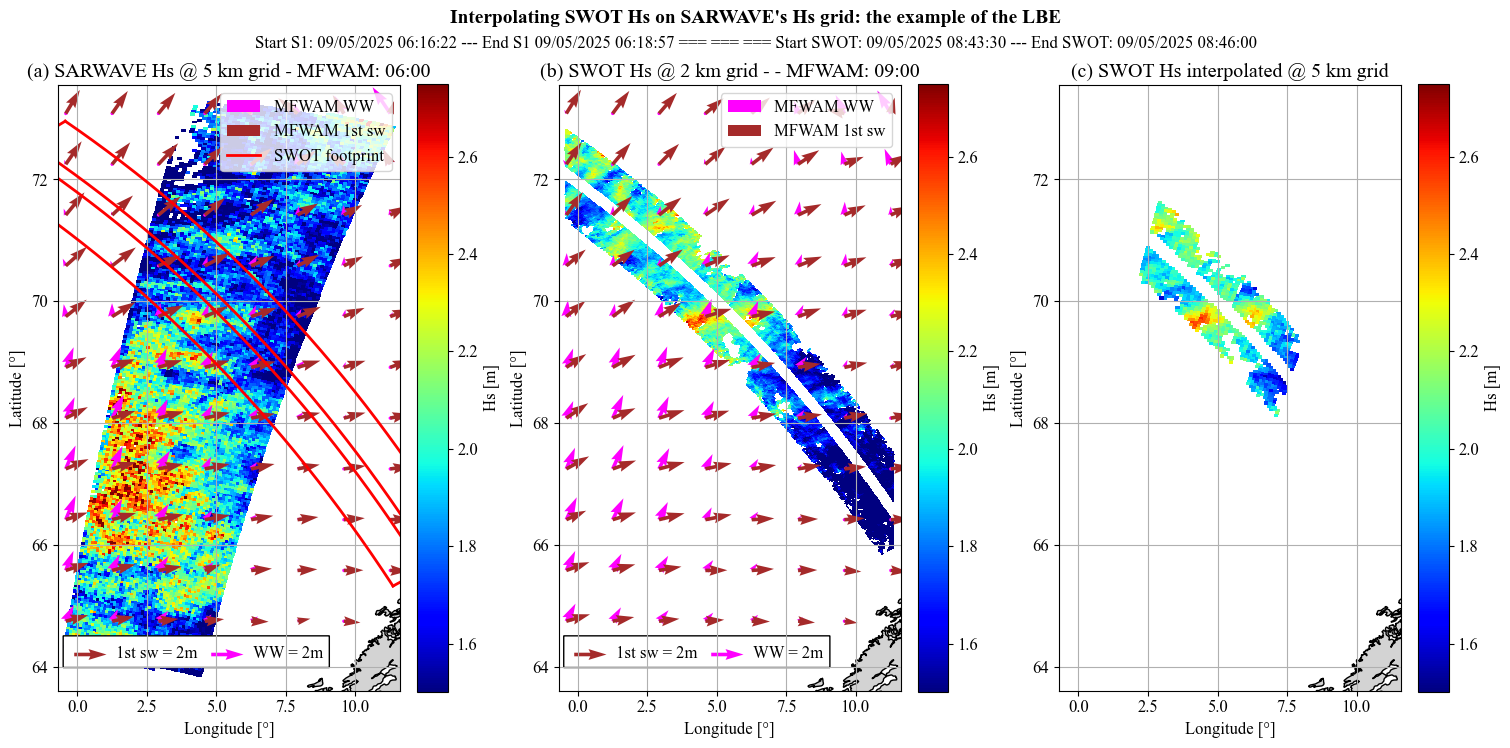

In [10]:
########################################################################
#                                                                      #
########################################################################
#### INTERPOLATING 2km x 2km SWOT grid onto 5km x 5 km IW SARWAVE grid #  
########################################################################
#                                                                      #
########################################################################

plt.rcParams.update({'font.size': 12})  
hs_min, hs_max = 1.5, 2.75

# Geographic scaling
Rt = 6400  # km
mean_lat_rad = np.radians((lat_map_min + lat_map_max)/2)
dx = Rt * np.cos(mean_lat_rad) * np.radians(lon_map_max - lon_map_min)
dy = Rt * np.radians(lat_map_max - lat_map_min)
scale_fact = dy / dx

print(f"dx (km): {dx:.2f}, dy (km): {dy:.2f}, scale: {scale_fact:.2f}")

# Full figure size
Lx = 5  # inches
Ly = Lx * scale_fact



# 2km x 2km SWOT images
lon_swot_grid = ds_swot.longitude.values
lat_swot_grid = ds_swot.latitude.values
swh_swot_grid = ds_swot.swh_karin.values
lon_swot_flat = ds_swot.longitude.values.ravel()
lat_swot_flat = ds_swot.latitude.values.ravel()
swh_swot_flat = ds_swot.swh_karin.values.ravel()
swot_points = np.vstack((lon_swot_flat, lat_swot_flat)).T

swot_lon_min, swot_lon_max = lon_swot_flat.min(), lon_swot_flat.max()
swot_lat_min, swot_lat_max = lat_swot_flat.min(), lat_swot_flat.max()

swh_swot_interp_array_tot = np.array([])
swh_iw_array_tot = np.array([]) # ça va être flatten pour la régression linéaire qu'on fait ensuite
swh_iw_conf_array_tot = np.array([])
                            
#fig, axs = plt.subplots(1, 3, figsize=(15, 6), constrained_layout = True)
n_p = 3
fig, axs = plt.subplots(1, n_p, figsize=(3*Lx, Ly), constrained_layout = True)

# Set the same aspect ratio for all subplots
for ax in axs.flat:
    ax.set_aspect(scale_fact)  # or use dy/dx if you want numerical precision: ax.set_aspect(scale_fact)



min_xx, max_xx = 100, -100
diff_max = 0

# Plot original fine grid
im1 = axs[1].pcolormesh(lon_swot_grid, lat_swot_grid, swh_swot_grid, shading='auto', cmap='jet', vmin=hs_min, vmax=hs_max)



INTERP_SWOT_ON_IW_LIST = []


# 5km x 5km IW images
for ds in ds_mega_list:
#ds = ds3
    iw_lon_grid = ds.longitude.values
    iw_lat_grid = ds.latitude.values
    interp_points = np.vstack((iw_lon_grid.ravel(), iw_lat_grid.ravel())).T
    
    # Mask for overlapping region
    mask = (
        (iw_lon_grid >= swot_lon_min) & (iw_lon_grid <= swot_lon_max) &
        (iw_lat_grid >= swot_lat_min) & (iw_lat_grid <= swot_lat_max)
    )
    
    # Only interpolate where mask is True
    swot_interp_on_iw_grid = np.full(iw_lon_grid.shape, np.nan)  # NaN elsewhere
    
    # Apply interpolation
    interpolated_values = griddata(
        swot_points, swh_swot_flat, 
        (iw_lon_grid[mask], iw_lat_grid[mask]), 
        method='linear'
    )
    
    swot_interp_on_iw_grid[mask] = interpolated_values
    INTERP_SWOT_ON_IW_LIST.append(swot_interp_on_iw_grid)
    
    swh_swot_interp_array_tot = np.concatenate((swh_swot_interp_array_tot,swot_interp_on_iw_grid.ravel()))
    
    #print("swot_shape",swot_interp_on_iw_grid.shape)
    
       
    lon, lat = ds.variables["longitude"].values, ds.variables["latitude"].values
    hsml = ds.variables["hs_most_likely"].values
    swh_iw_array_tot = np.concatenate((swh_iw_array_tot, hsml.ravel()))

    hs_conf = ds.variables["hs_conf"].values
    mask_confident = hs_conf > conf_rate_min # hs_conf [-1,1] so 0 is 50%-50%
    hsml_confident = np.ones(hsml.shape)*np.nan
    hsml_confident[mask_confident] = hsml[mask_confident]
    swh_iw_conf_array_tot = np.concatenate((swh_iw_conf_array_tot,  hsml_confident.ravel()))
    #print("hsml_shape",hsml.shape)

    try:
        diff = round(np.nanmax(np.abs(hsml - swot_interp_on_iw_grid)),1)
        if diff > diff_max:
            diff_max = diff
    except ValueError:
        pass
        
     
    try:
        min_iw_i, max_iw_i = np.nanmin([np.nanmin(swot_interp_on_iw_grid), np.nanmin(hsml)]),  np.nanmax([np.nanmax(swot_interp_on_iw_grid), np.nanmax(hsml)])
        if min_iw_i < min_xx:
            min_xx = min_iw_i
        if max_iw_i > max_xx:
            max_xx = max_iw_i
    except ValueError:
        pass


for i, ds in enumerate(ds_mega_list):
    swot_interp_on_iw_grid = INTERP_SWOT_ON_IW_LIST[i]

    iw_lon_grid = ds.longitude.values
    iw_lat_grid = ds.latitude.values
    
    lon, lat = ds.variables["longitude"].values, ds.variables["latitude"].values
    hsml = ds.variables["hs_most_likely"].values
    
    hs_conf = ds.variables["hs_conf"].values
    mask_confident = hs_conf > conf_rate_min # hs_conf [-1,1] so 0 is 50%-50%
    hsml_confident = np.ones(hsml.shape)*np.nan
    hsml_confident[mask_confident] = hsml[mask_confident]
    

    im0 = axs[0].pcolormesh(lon, lat, hsml_confident, cmap="jet", vmin=hs_min, vmax=hs_max)

    im2 = axs[2].pcolormesh(lon, lat, swot_interp_on_iw_grid, shading='auto', cmap='jet', vmin=hs_min, vmax=hs_max)

    #im3 = axs[3].pcolormesh(lon, lat, swot_interp_on_iw_grid-hsml_confident, cmap="seismic", vmin=-diff_max, vmax=diff_max)

########################################## MFWAM 1 ##########################################

### Chargement de MFWAM
time_mfwam_idx = 1 # 06:00:00
ds_mfwam = xr.open_dataset(r"data/mfwam/mfwamglocep_2025050900_R20250510_00H.nc")
ds_mfwam = ds_mfwam.where((ds_mfwam.longitude >= lon_map_min) & (ds_mfwam.longitude <= lon_map_max) & (ds_mfwam.latitude >= lat_map_min) & (ds_mfwam.latitude <= lat_map_max), drop=True)

X_mfwam, Y_mfwam = ds_mfwam.longitude.values, ds_mfwam.latitude.values
X_mfwam_grid, Y_mfwam_grid = np.meshgrid(X_mfwam, Y_mfwam)

mean_wave_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR.values
hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0.values
u_mean_wave_dir = hs*np.sin(np.pi*(mean_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_mean_wave_dir = hs*np.cos(np.pi*(mean_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

sw1_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_SW1.values
sw1_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_SW1.values
u_sw1_dir = sw1_hs*np.sin(np.pi*(sw1_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_sw1_dir = sw1_hs*np.cos(np.pi*(sw1_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

sw2_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_SW2.values
sw2_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_SW2.values
u_sw2_dir = sw2_hs*np.sin(np.pi*(sw2_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_sw2_dir = sw2_hs*np.cos(np.pi*(sw2_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

ww_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_WW.values
ww_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_WW.values
u_ww_dir = ww_hs*np.sin(np.pi*(ww_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_ww_dir = ww_hs*np.cos(np.pi*(ww_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

max_mag = np.max([np.nanmax(sw1_hs), np.nanmax(ww_hs)])
arrow_length = 0.1#0.07
scale = max_mag / arrow_length

## MFWAM
t_mfwam = ds_mfwam.isel(time=time_mfwam_idx).time.values
# Convert np.datetime64 to Python datetime
t_mfwam = t_mfwam.astype('datetime64[s]').tolist()
# Format the datetime object to desired string format
#t_mfwam_formatted = t_mfwam.strftime("%d/%m/%Y %H:%M:%S")
t_mfwam_formatted = t_mfwam.strftime("%H:%M:%S")


# Add fixed size white rectangle
rect = patches.FancyBboxPatch(
    (-0.5, 64),  # bottom left corner in data coords
    width=9.55, height=0.5, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
axs[0].add_patch(rect)


show_mfwam_dir = True
if show_mfwam_dir:
    step_mfwam = 10
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::step_mfwam] ,u_mean_wave_dir[::step_mfwam,::step_mfwam], v_mean_wave_dir[::step_mfwam,::step_mfwam], color = "blue", label="MFWAM mean dir", linewidth = 1)
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::steµp_mfwam] ,u_sw2_dir[::step_mfwam,::step_mfwam], v_sw2_dir[::step_mfwam,::step_mfwam], color = "purple", alpha = 0.5, label="MFWAM 2nd sw", linewidth = 1)
    #q = axs[0].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], color="black", scale=0.8*scale, width=3.6*0.0035)#width = 0.0035)#, scale_units='xy')
    #axs[0].quiverkey(q, X=0.52, Y=0.06, U=1,label='WW = 1m ',color = "black", labelpos='E')
    q = axs[0].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], color="magenta", label="MFWAM WW", scale=scale, width=3*0.0035)#width = 0.0035)#, scale_units='xy')
    axs[0].quiverkey(q, X=0.54, Y=0.06, U=2,label='WW = 2m ',color = "magenta", labelpos='E')
    #q = axs[0].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], color = "white", scale=0.8*scale, width=3.6*0.0035)
    #axs[0].quiverkey(q, X=0.12, Y=0.06, U=1,label='1st = 1m ',color = "white", labelpos='E')
    q = axs[0].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], color = "brown", label="MFWAM 1st sw", scale=scale, width=3*0.0035)
    axs[0].quiverkey(q, X=0.14, Y=0.06, U=2,label='1st sw = 2m ',color = "brown", labelpos='E')

########################################## MFWAM 2 ##########################################

### Chargement de MFWAM
time_mfwam_idx = 2 # 09:00:00
ds_mfwam = xr.open_dataset(r"data/mfwam/mfwamglocep_2025050900_R20250510_00H.nc")
ds_mfwam = ds_mfwam.where((ds_mfwam.longitude >= lon_map_min) & (ds_mfwam.longitude <= lon_map_max) & (ds_mfwam.latitude >= lat_map_min) & (ds_mfwam.latitude <= lat_map_max), drop=True)

X_mfwam, Y_mfwam = ds_mfwam.longitude.values, ds_mfwam.latitude.values
X_mfwam_grid, Y_mfwam_grid = np.meshgrid(X_mfwam, Y_mfwam)

mean_wave_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR.values
hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0.values
u_mean_wave_dir = hs*np.sin(np.pi*(mean_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_mean_wave_dir = hs*np.cos(np.pi*(mean_wave_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

sw1_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_SW1.values
sw1_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_SW1.values
u_sw1_dir = sw1_hs*np.sin(np.pi*(sw1_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_sw1_dir = sw1_hs*np.cos(np.pi*(sw1_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

sw2_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_SW2.values
sw2_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_SW2.values
u_sw2_dir = sw2_hs*np.sin(np.pi*(sw2_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_sw2_dir = sw2_hs*np.cos(np.pi*(sw2_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

ww_dir = ds_mfwam.isel(time=time_mfwam_idx).VMDR_WW.values
ww_hs = ds_mfwam.isel(time=time_mfwam_idx).VHM0_WW.values
u_ww_dir = ww_hs*np.sin(np.pi*(ww_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180
v_ww_dir = ww_hs*np.cos(np.pi*(ww_dir + 180)/180) # + 180 parce que la direction des vagues = d'où elles viennent, mais si on veut voir où elles vont avec quiver, +180

## MFWAM
t_mfwam = ds_mfwam.isel(time=time_mfwam_idx).time.values
# Convert np.datetime64 to Python datetime
t_mfwam = t_mfwam.astype('datetime64[s]').tolist()
# Format the datetime object to desired string format
#t_mfwam_formatted = t_mfwam.strftime("%d/%m/%Y %H:%M:%S")
t_mfwam_formatted = t_mfwam.strftime("%H:%M:%S")


# Add fixed size white rectangle
rect = patches.FancyBboxPatch(
    (-0.5, 64),  # bottom left corner in data coords
    width=9.55, height=0.5, boxstyle="round,pad=0.01", linewidth=1, edgecolor='black', facecolor='white', alpha=1)
axs[1].add_patch(rect)


show_mfwam_dir = True
if show_mfwam_dir:
    step_mfwam = 10
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::step_mfwam] ,u_mean_wave_dir[::step_mfwam,::step_mfwam], v_mean_wave_dir[::step_mfwam,::step_mfwam], color = "blue", label="MFWAM mean dir", linewidth = 1)
    #plt.quiver(X_mfwam_grid[::step_mfwam,::step_mfwam], Y_mfwam_grid[::step_mfwam,::steµp_mfwam] ,u_sw2_dir[::step_mfwam,::step_mfwam], v_sw2_dir[::step_mfwam,::step_mfwam], color = "purple", alpha = 0.5, label="MFWAM 2nd sw", linewidth = 1)
    #q = axs[1].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], color="black", scale=0.8*scale, width=3.6*0.0035)#width = 0.0035)#, scale_units='xy')
    #axs[1].quiverkey(q, X=0.52, Y=0.06, U=1,label='WW = 1m ',color = "black", labelpos='E')
    q = axs[1].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_ww_dir[step_mfwam::step_mfwam,::2*step_mfwam], color="magenta", label="MFWAM WW", scale=scale, width=3*0.0035)#width = 0.0035)#, scale_units='xy')
    axs[1].quiverkey(q, X=0.54, Y=0.06, U=2,label='WW = 2m ',color = "magenta", labelpos='E')
    #q = axs[1].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], color = "white", scale=0.8*scale, width=3.6*0.0035)
    #axs[1].quiverkey(q, X=0.12, Y=0.06, U=1,label='1st = 1m ',color = "white", labelpos='E')
    q = axs[1].quiver(X_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam], Y_mfwam_grid[step_mfwam::step_mfwam,::2*step_mfwam] ,u_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], v_sw1_dir[step_mfwam::step_mfwam,::2*step_mfwam], color = "brown", label="MFWAM 1st sw", scale=scale, width=3*0.0035)
    axs[1].quiverkey(q, X=0.14, Y=0.06, U=2,label='1st sw = 2m ',color = "brown", labelpos='E')

############################################################################################


#sf_world = shp.Reader(r"/home1/datawork/msimonne/SWOT_toy_data/DATA/COASTLINE/GSHHS_c_L1.shp") # shapefile with global coastlines
#sf_world = shp.Reader(r"data/shapefiles/ne_110m_coastline/ne_110m_coastline.shp") 
sf_world = shp.Reader(r"data/shapefiles/ne_10m_coastline/ne_10m_coastline.shp") 

axs[1].set_title("(b) SWOT Hs @ 2 km grid - - MFWAM: 09:00")
fig.colorbar(im1, ax=axs[1], orientation='vertical', label = "Hs [m]", shrink = 0.56)
axs[1].legend(loc="upper right")


axs[0].set_title("(a) SARWAVE Hs @ 5 km grid - MFWAM: 06:00")
st.plot_swot_footprint(ds_swot, ax=axs[0], lw=2)
fig.colorbar(im0, ax=axs[0], orientation='vertical', label = "Hs [m]", shrink = 0.56)
axs[0].legend(loc="upper right")

axs[2].set_title("(c) SWOT Hs interpolated @ 5 km grid")
fig.colorbar(im2, ax=axs[2], orientation='vertical', label = "Hs [m]", shrink = 0.56)

#axs[3].set_title("(d) SWOT Hs - SARWAVE Hs")
#fig.colorbar(im3, ax=axs[3], orientation='vertical', label = "Difference in Hs [m]")

step_deg = 0.25
plt.rcParams.update({'font.size': 26})  
for i in range(n_p):
    axs[i].set_xlim(lon_map_min-step_deg, lon_map_max+step_deg)
    axs[i].set_ylim(lat_map_min-step_deg, lat_map_max+step_deg)
    axs[i].set_xlabel("Longitude [°]")
    axs[i].set_ylabel("Latitude [°]")
    axs[i].grid()
    # Affichage du trait de côte
    st.show_shp(axs[i],sf_world, zorder=0, color='lightgrey')

plt.rcParams.update({'font.size': 12})  

pretitle = "the Agulhas current"
pretitle = "the Lofoten Eddy"


fig.suptitle("Interpolating SWOT Hs on SARWAVE's Hs grid: the example of the LBE", ha='center', fontproperties=font_bold, x=0.5, y=0.845, fontsize=14)
fig.text(x=0.5, y=0.81, s="Start S1: {} --- End S1 {} === === === Start SWOT: {} --- End SWOT: {}".format(dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'), dt_end_max.strftime('%d/%m/%Y %H:%M:%S'), t_ini_swot_formatted, t_end_swot_formatted), ha="center")
png_name = year_and_day[:4] + year_and_day[5:8]
fig.savefig(fname="output_images/SWOT_IW_SWH_colocs/{}".format(png_name), bbox_inches='tight')

fig.show()

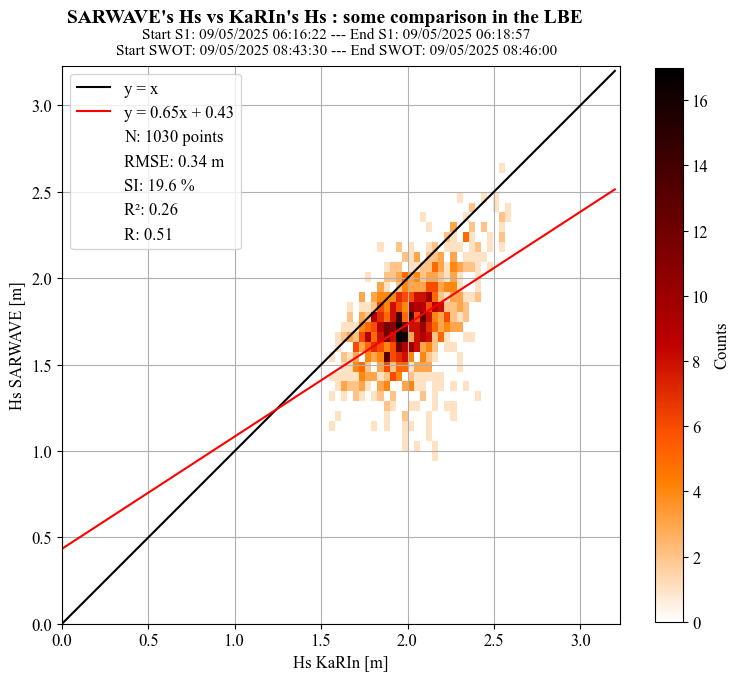

In [11]:
########################################
# DENSITY SCATTER PLOT SARWAVE vs SWOT #
########################################


keep_confident = True


if keep_confident:
    x_obs = swh_swot_interp_array_tot[(np.isfinite(swh_swot_interp_array_tot)) & (np.isfinite(swh_iw_conf_array_tot))]
    y_obs = swh_iw_conf_array_tot[(np.isfinite(swh_swot_interp_array_tot)) & (np.isfinite(swh_iw_conf_array_tot))]

else:
    x_obs = swh_swot_interp_array_tot[(np.isfinite(swh_swot_interp_array_tot)) & (np.isfinite(swh_iw_array_tot))]
    y_obs = swh_iw_array_tot[(np.isfinite(swh_swot_interp_array_tot)) & (np.isfinite(swh_iw_array_tot))]

coeffs = np.polyfit(x_obs, y_obs, deg=1)

fig = plt.figure(figsize=(9, 9))

# DENSITY SCATTERPLOT REPLACEMENT
plt.hist2d(x_obs, y_obs, bins=30, cmap='gist_heat_r')# norm=plt.cm.colors.LogNorm())  # log scale for better visibility
plt.colorbar(orientation='vertical', label='Counts', shrink=0.8)


x_id = np.arange(min_xx, max_xx, 0.1)
plt.plot(x_id, x_id, color="black", label="y = x")
a, b = coeffs[0], coeffs[1]
if b > 0:
    plt.plot(x_id, a * x_id + b, color="red", label=f"y = {round(a,2)}x + {round(b,2)}")
else:
    plt.plot(x_id, a * x_id + b, color="red", label=f"y = {round(a,2)}x - {round(abs(b),2)}")


RMSE = round(np.sqrt(np.mean((x_obs-y_obs)**2)),2)


y_pred = a*x_obs+b
R2 = round(1 - np.sum((y_obs - y_pred)**2) / np.sum((y_obs - np.mean(y_obs))**2), 2)
R = round(np.sqrt(R2), 2)

N = x_obs.shape[0]

SI = round(100* RMSE / np.mean(y_obs), 1)


plt.scatter(-1,-1, color="white", label=f"N: {N} points")    
plt.scatter(-1,-1, color="white", label=f"RMSE: {RMSE} m")
plt.scatter(-1,-1, color="white", label=f"SI: {SI} %")
plt.scatter(-1,-1, color="white", label=f"R²: {R2}")
plt.scatter(-1,-1, color="white", label=f"R: {R}")


plt.grid()
plt.axis('scaled')
fig.text(0.13,0.81, "SARWAVE's Hs vs KaRIn's Hs : some comparison in the LBE\n \n", fontsize=14, fontproperties=font_bold)
fig.text(0.43, 0.8, " Start S1: {} --- End S1: {} \n Start SWOT: {} --- End SWOT: {} \n ".format(
    dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'),
    dt_end_max.strftime('%d/%m/%Y %H:%M:%S'),
    t_ini_swot_formatted,
    t_end_swot_formatted),
    ha='center', fontsize=11)
plt.xlabel("Hs KaRIn [m]")
plt.ylabel("Hs SARWAVE [m]")
plt.xlim(min_xx, max_xx)
plt.ylim(min_xx, max_xx)
plt.legend()
plt.savefig(fname="output_images/SWOT_IW_SWH_colocs/{}_scatterplot".format(png_name), bbox_inches='tight')

plt.show()


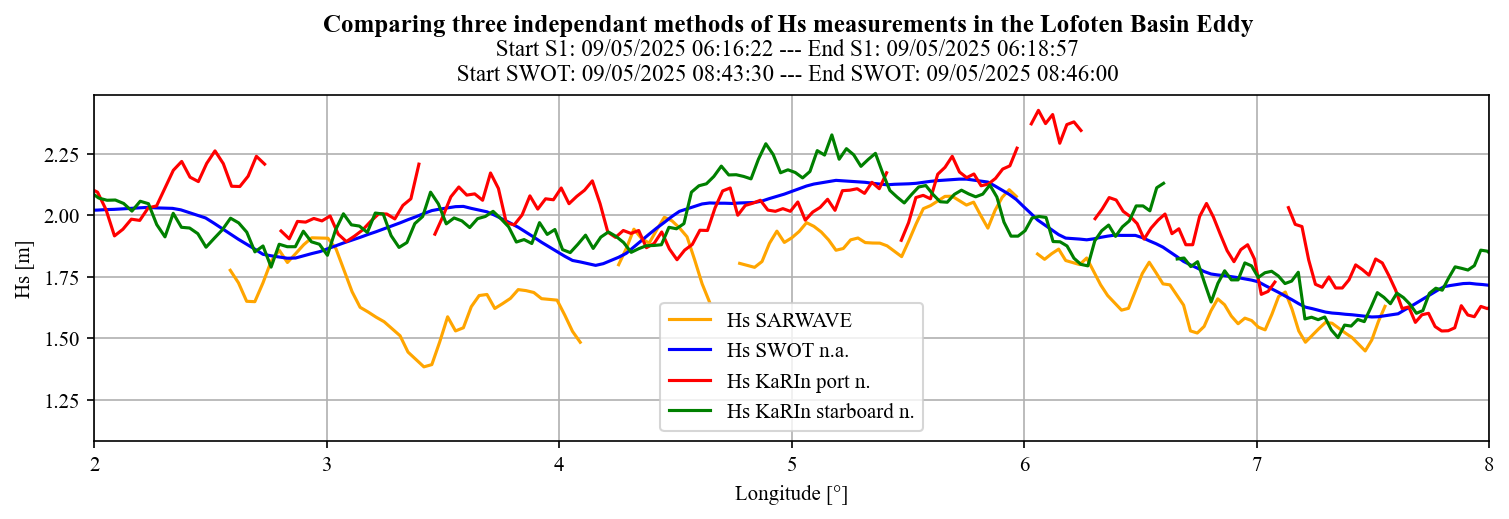

In [12]:
########################################
# NADIR CHECK: 3 DIFFERENT INSTRUMENTS #
########################################


fig = plt.figure(figsize=(12,3),dpi=150)
plt.rcParams.update({'font.size': 10})  
lat_swot_nadir = ds_swot.latitude.isel(num_pixels=34).values
lon_swot_nadir = ds_swot.longitude.isel(num_pixels=34).values

interp_points = np.vstack((lon_swot_nadir, lat_swot_nadir)).T
    
# Mask for overlapping region
mask = (
    (lon_swot_nadir >= swot_lon_min) & (lon_swot_nadir <= swot_lon_max) &
    (lat_swot_nadir >= swot_lat_min) & (lat_swot_nadir <= swot_lat_max)
)
    
for i, ds in enumerate(ds_mega_list):
    lon_sar_flat = ds.longitude.values.ravel()
    lat_sar_flat = ds.latitude.values.ravel()
    phs0_sar_flat = ds.phs0_most_likely.values.ravel()
    swh_sar_flat = ds.hs_most_likely.values.ravel()
    sar_points = np.vstack((lon_sar_flat, lat_sar_flat)).T
    


    # Only interpolate where mask is True
    sar_interp_on_swot_nadir = np.full(lat_swot_nadir.shape, np.nan)  # NaN elsewhere
    phs0_sar_interp_on_swot_nadir = np.full(lat_swot_nadir.shape, np.nan)  # NaN elsewhere
    
    # Apply interpolation
    sar_interpolated_values_on_swot_nadir = griddata(sar_points, swh_sar_flat, (lon_swot_nadir[mask], lat_swot_nadir[mask]), method='linear')
    phs0_sar_interpolated_values_on_swot_nadir = griddata(sar_points, phs0_sar_flat, (lon_swot_nadir[mask], lat_swot_nadir[mask]), method='linear')
    
    sar_interp_on_swot_nadir[mask] = sar_interpolated_values_on_swot_nadir
    phs0_sar_interp_on_swot_nadir[mask] = phs0_sar_interpolated_values_on_swot_nadir

    if i==0:
        plt.plot(lon_swot_nadir, sar_interp_on_swot_nadir, color="orange",label="Hs SARWAVE")
        #plt.plot(phs0_sar_interp_on_swot_nadir, lat_swot_nadir, color="orange", linestyle = "dashed", label="pHs0 SARWAVE")
    else:
        plt.plot(lon_swot_nadir, sar_interp_on_swot_nadir, color="orange")
        #plt.plot(phs0_sar_interp_on_swot_nadir, lat_swot_nadir, color="orange", linestyle = "dashed")
        
# Plot nadir altimeter (averaged over pixels)
swh_swot_nadir = ds_swot.swh_nadir_altimeter.values[:,22] #
plt.plot(lon_swot_nadir, swh_swot_nadir, label="Hs SWOT n.a.", color="blue")

#swh_swot_nadir =  ds_swot.swh_nadir_altimeter.mean(dim="num_pixels")
#plt.plot(lat_swot_nadir, swh_swot_nadir, label="SWOT nadir altimeter", color="pink")


# Plot Karin left of nadir (pixel 29)
swh_left = ds_swot.swh_karin.isel(num_pixels=28)
lat_left = ds_swot.latitude.isel(num_pixels=28)
lon_left = ds_swot.longitude.isel(num_pixels=28)

plt.plot(lon_left, swh_left, label="Hs KaRIn port n.", color="red")

# Plot Karin right of nadir (pixel 39)
swh_right = ds_swot.swh_karin.isel(num_pixels=39)
lat_right = ds_swot.latitude.isel(num_pixels=39)
lon_right = ds_swot.longitude.isel(num_pixels=39)

plt.plot(lon_right, swh_right, label="Hs KaRIn starboard n.", color="green")
plt.legend()

plt.rcParams.update({'font.size': 12})  

plt.xlim(2,8)
plt.xlabel("Longitude [°]")
plt.ylabel("Hs [m]")
#plt.axis("scaled")
plt.grid()
plt.title("Comparing three independant methods of Hs measurements in the Lofoten Basin Eddy \n \n ", fontproperties=font_bold, fontsize=12)
fig.text(0.51, 0.855, " Start S1: {} --- End S1: {} \n Start SWOT: {} --- End SWOT: {} \n ".format(
    dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'),
    dt_end_max.strftime('%d/%m/%Y %H:%M:%S'),
    t_ini_swot_formatted,
    t_end_swot_formatted),
    ha='center', fontsize=11)
plt.savefig(fname="output_images/SWOT_IW_SWH_colocs/{}_instru_compared".format(png_name), bbox_inches='tight')
plt.show()



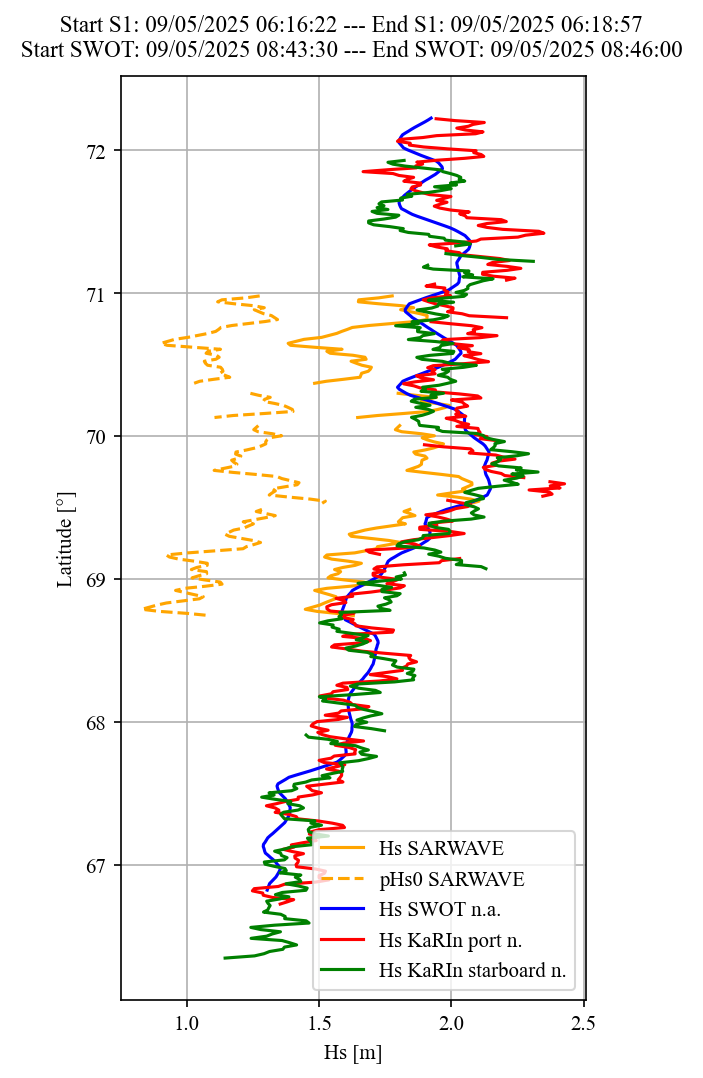

In [37]:
########################################
# NADIR CHECK: 3 DIFFERENT INSTRUMENTS # 
########################################

# A la verticale pour le cas des Aiguilles où SARWAVE diverge complètement à cause du front de vent soudain


fig = plt.figure(figsize=(4,8),dpi=150)
plt.rcParams.update({'font.size': 10})  
lat_swot_nadir = ds_swot.latitude.isel(num_pixels=34).values
lon_swot_nadir = ds_swot.longitude.isel(num_pixels=34).values

interp_points = np.vstack((lon_swot_nadir, lat_swot_nadir)).T
    
# Mask for overlapping region
mask = (
    (lon_swot_nadir >= swot_lon_min) & (lon_swot_nadir <= swot_lon_max) &
    (lat_swot_nadir >= swot_lat_min) & (lat_swot_nadir <= swot_lat_max)
)
    
for i, ds in enumerate(ds_mega_list):
    lon_sar_flat = ds.longitude.values.ravel()
    lat_sar_flat = ds.latitude.values.ravel()
    phs0_sar_flat = ds.phs0_most_likely.values.ravel()
    swh_sar_flat = ds.hs_most_likely.values.ravel()
    sar_points = np.vstack((lon_sar_flat, lat_sar_flat)).T
    


    # Only interpolate where mask is True
    sar_interp_on_swot_nadir = np.full(lat_swot_nadir.shape, np.nan)  # NaN elsewhere
    phs0_sar_interp_on_swot_nadir = np.full(lat_swot_nadir.shape, np.nan)  # NaN elsewhere
    
    # Apply interpolation
    sar_interpolated_values_on_swot_nadir = griddata(sar_points, swh_sar_flat, (lon_swot_nadir[mask], lat_swot_nadir[mask]), method='linear')
    phs0_sar_interpolated_values_on_swot_nadir = griddata(sar_points, phs0_sar_flat, (lon_swot_nadir[mask], lat_swot_nadir[mask]), method='linear')
    
    sar_interp_on_swot_nadir[mask] = sar_interpolated_values_on_swot_nadir
    phs0_sar_interp_on_swot_nadir[mask] = phs0_sar_interpolated_values_on_swot_nadir

    if i==0:
        plt.plot(sar_interp_on_swot_nadir, lat_swot_nadir, color="orange",label="Hs SARWAVE")
        plt.plot(phs0_sar_interp_on_swot_nadir, lat_swot_nadir, color="orange", linestyle = "dashed", label="pHs0 SARWAVE")
    else:
        plt.plot(sar_interp_on_swot_nadir, lat_swot_nadir, color="orange")
        plt.plot(phs0_sar_interp_on_swot_nadir, lat_swot_nadir, color="orange", linestyle = "dashed")
        
# Plot nadir altimeter (averaged over pixels)
swh_swot_nadir = ds_swot.swh_nadir_altimeter.values[:,22] #
plt.plot(swh_swot_nadir, lat_swot_nadir, label="Hs SWOT n.a.", color="blue")

#swh_swot_nadir =  ds_swot.swh_nadir_altimeter.mean(dim="num_pixels")
#plt.plot(lat_swot_nadir, swh_swot_nadir, label="SWOT nadir altimeter", color="pink")


# Plot Karin left of nadir (pixel 29)
swh_left = ds_swot.swh_karin.isel(num_pixels=28)
lat_left = ds_swot.latitude.isel(num_pixels=28)
lon_left = ds_swot.longitude.isel(num_pixels=28)


plt.plot(swh_left, lat_left, label="Hs KaRIn port n.", color="red")

# Plot Karin right of nadir (pixel 39)
swh_right = ds_swot.swh_karin.isel(num_pixels=39)
lat_right = ds_swot.latitude.isel(num_pixels=39)
lon_right = ds_swot.longitude.isel(num_pixels=39)


plt.plot(swh_right, lat_right, label="Hs KaRIn starboard n.", color="green")
plt.legend()

plt.rcParams.update({'font.size': 12})  

plt.ylabel("Latitude [°]")
plt.xlabel("Hs [m]")
#plt.axis("scaled")
plt.grid()
#plt.title("Comparing three independant methods of Hs measurements in the Lofoten Eddy \n \n \n ", fontproperties=font_bold, fontsize=12)
fig.text(0.51, 0.875, " Start S1: {} --- End S1: {} \n Start SWOT: {} --- End SWOT: {} \n ".format(
    dt_ini_min.strftime('%d/%m/%Y %H:%M:%S'),
    dt_end_max.strftime('%d/%m/%Y %H:%M:%S'),
    t_ini_swot_formatted,
    t_end_swot_formatted),
    ha='center', fontsize=11)
plt.savefig(fname="output_images/SWOT_IW_SWH_colocs/{}_instru_compared".format(png_name), bbox_inches='tight')
plt.show()

